In [39]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns

In [ ]:
with open('./dataset/cleaned_datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)

min_max_train_df_with_label = datasets['min_max_scale_pca']['train']
standard_train_df_with_label = datasets['standard_scale_pca']['train']

# remove the Churn column
min_max_train_df = min_max_train_df_with_label.drop(columns=['Churn'])
standard_train_df = standard_train_df_with_label.drop(columns=['Churn'])

# remove the categorical columns: State_label
min_max_train_df = min_max_train_df.drop(columns=['State_label'])
standard_train_df = standard_train_df.drop(columns=['State_label'])

min_max_train_df_with_label = min_max_train_df_with_label.drop(columns=['State_label'])
standard_train_df_with_label = standard_train_df_with_label.drop(columns=['State_label'])


In [30]:
standard_train_df.head()
min_max_train_df.head()

,State_freq,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.019505,0.524793,0,0.50,0.755701,0.68750,0.542755,0.582353,0.572161,0.436090,0.500
1,0.024756,0.438017,0,0.52,0.460661,0.76875,0.537531,0.605882,0.599772,0.526316,0.685
2,0.018755,0.561983,0,0.00,0.693843,0.71250,0.333242,0.647059,0.338457,0.533835,0.610
3,0.024756,0.342975,1,0.00,0.853478,0.44375,0.170195,0.517647,0.436095,0.421053,0.330
4,0.019505,0.305785,1,0.00,0.475200,0.70625,0.407754,0.717647,0.407629,0.661654,0.505


In [31]:
def kmeans_elbow_method(data, start, step, num_steps=10, **params):
    mse_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        mse_scores.append(model.inertia_)
    return mse_scores

def kmeans_silhouette_scores(data, start, step, num_steps=10, **params):
    silhouette_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        silhouette_scores.append(silhouette_score(data, model.labels_, random_state=42))
    return silhouette_scores

def plot_results(results_dict, metric_name, num_steps=10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, (scale_type, values) in enumerate(results_dict.items()):
        x_values = np.arange(values['start'], values['start'] + num_steps * values['step'], values['step'])
        ax[i].plot(x_values, values['results'], marker='o')
        ax[i].set_title(f'{scale_type} Scaled Data ({metric_name})')
        ax[i].set_xlabel('Number of Clusters' if 'KMeans' in metric_name else 'Epsilon (eps)')
        ax[i].set_ylabel(metric_name)
        ax[i].grid(True)
    
    plt.tight_layout()
    plt.show()



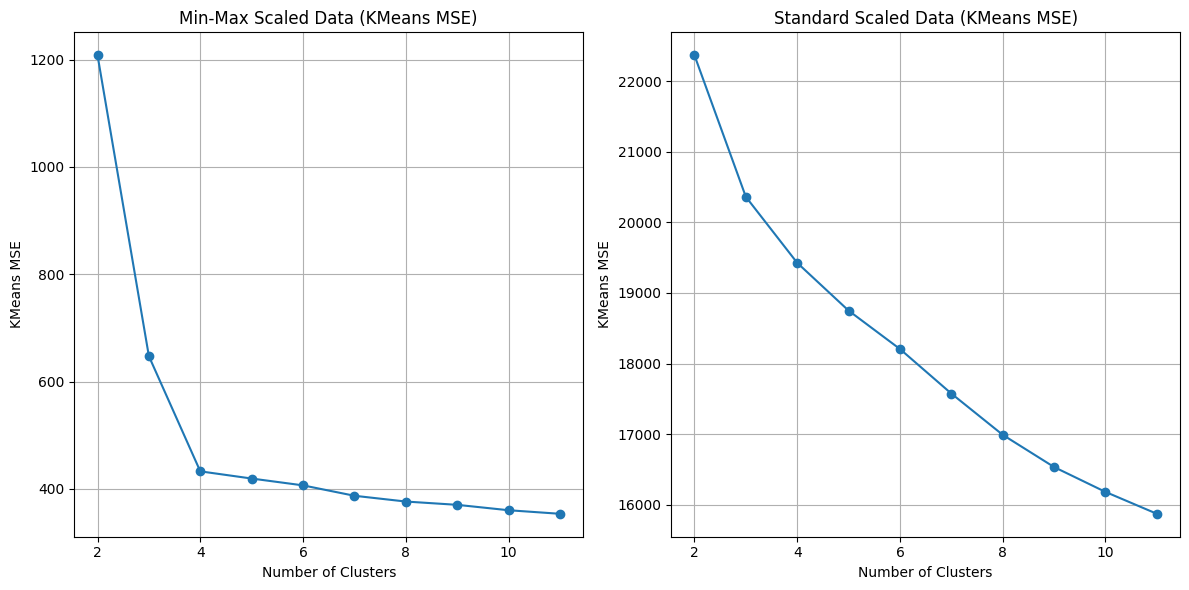

In [60]:
scaling_params = {
    'Min-Max': {'start': 2, 'step': 1},
    'Standard': {'start': 2, 'step': 1}
}

scaling_params['Min-Max']['results'] = kmeans_elbow_method(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], n_init='auto', init='k-means++', random_state=42)
scaling_params['Standard']['results'] = kmeans_elbow_method(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], n_init='auto', init='k-means++', random_state=42)
plot_results(scaling_params, metric_name='KMeans MSE')

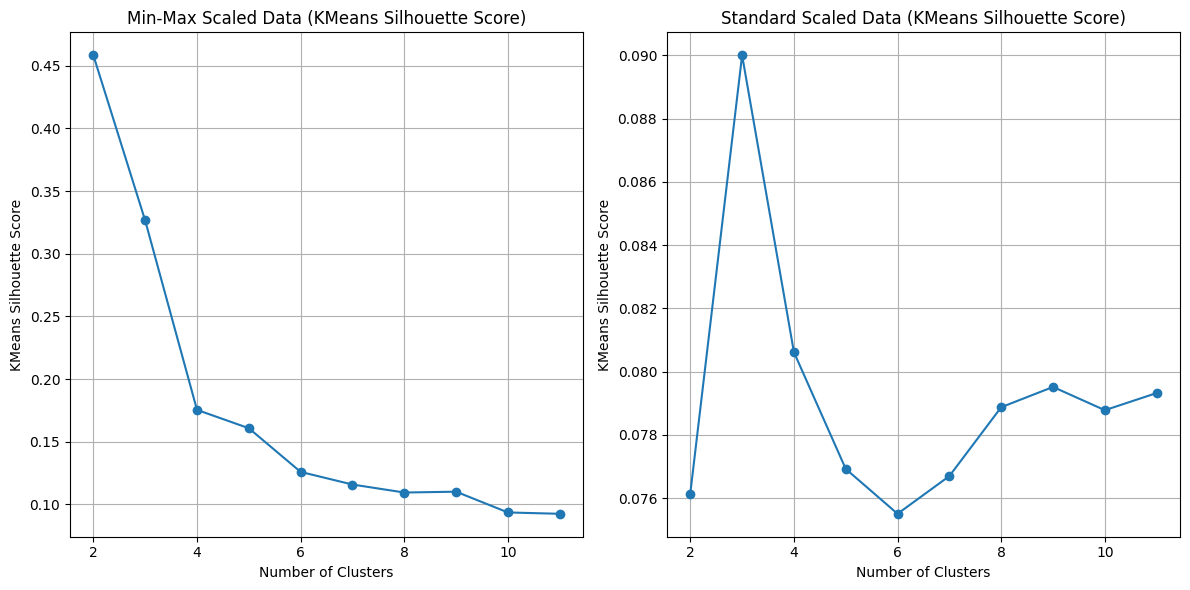

In [33]:
scaling_params = {
    'Min-Max': {'start': 2, 'step': 1},
    'Standard': {'start': 2, 'step': 1}
}

scaling_params['Min-Max']['results'] = kmeans_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], n_init='auto', init='k-means++', random_state=42)
scaling_params['Standard']['results'] = kmeans_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], n_init='auto', init='k-means++', random_state=42)
plot_results(scaling_params, metric_name='KMeans Silhouette Score')

​Based on the Elbow method, the plot indicates that 4 clusters are appropriate, as the curve forms an "elbow" at this point. Additionally, the Silhouette score analysis reveals relatively high values when the number of clusters is four or fewer. Therefore, we have selected 𝑘 = 4 as the optimal number of clusters. 


Besides, since data scaled using the min-max method has an obvious elbow in Elbow method, we will proceed with this scaling technique for our analysis.​


Next we will analyze what are the similarities within a cluster.

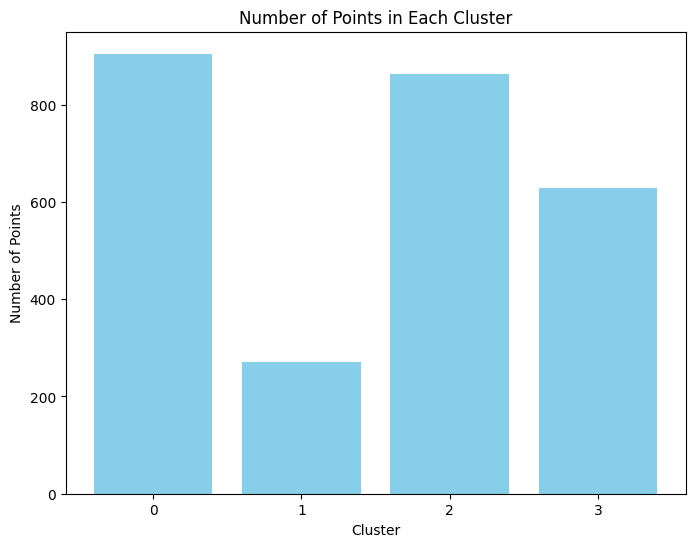

         Account length     Churn  Cluster  International plan  \
Cluster                                                          
0              0.283558  0.131492      0.0                 0.0   
1              0.423584  0.437037      1.0                 1.0   
2              0.544339  0.133256      2.0                 0.0   
3              0.408788  0.057325      3.0                 0.0   

         Number vmail messages  State_freq  Total day calls  \
Cluster                                                       
0                     0.002630    0.020484         0.616816   
1                     0.165185    0.020395         0.625347   
2                     0.006304    0.020440         0.640846   
3                     0.597611    0.020253         0.623099   

         Total day minutes  Total eve calls  Total eve minutes  \
Cluster                                                          
0                 0.522381         0.582749           0.546027   
1                 0.534441

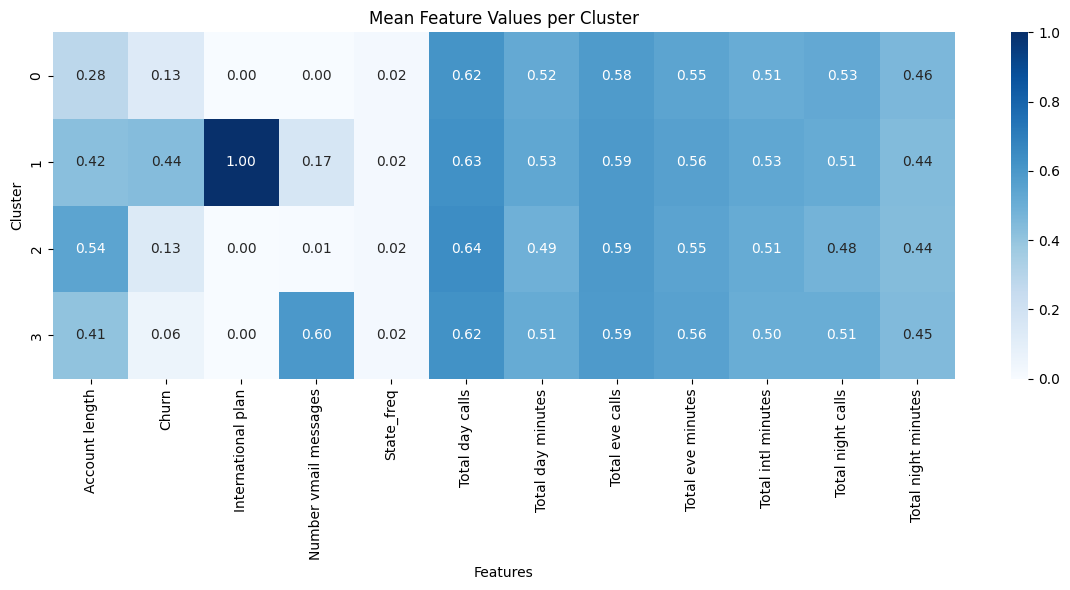

In [71]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
min_max_train_df['Cluster'] = kmeans.fit_predict(min_max_train_df)
min_max_train_df['Cluster'] = min_max_train_df['Cluster'].astype(int)

min_max_train_df_with_label['Cluster'] = min_max_train_df['Cluster']

cluster_sizes = min_max_train_df_with_label['Cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
plt.bar(cluster_sizes.index, cluster_sizes.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('Number of Points in Each Cluster')
plt.xticks(cluster_sizes.index)  # Ensure x-ticks correspond to cluster labels
plt.show()

cluster_summary = min_max_train_df_with_label.groupby(min_max_train_df['Cluster']).mean().sort_index(axis = 1)
print(cluster_summary)


# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.drop(columns=['Cluster'], errors='ignore'), annot=True, cmap='Blues', fmt=".2f", yticklabels=True)
plt.title("Mean Feature Values per Cluster")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

We visualized the size of each cluster and the mean feature values per cluster (Churn is also included). It can be shown that `Number vmail messages` and `International plan` differ most across clusters, and `Account length` is also a noticable feature. This indicates that the three features are important in predicting whether a customer will churn.

<Figure size 800x500 with 0 Axes>

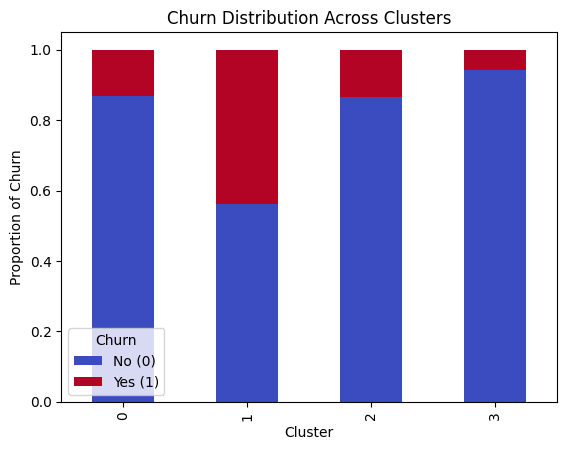

In [73]:
churn_distribution = min_max_train_df_with_label.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack()

# Visualize the churn distribution per cluster
plt.figure(figsize=(8, 5))
churn_distribution.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.xlabel("Cluster")
plt.ylabel("Proportion of Churn")
plt.title("Churn Distribution Across Clusters")
plt.legend(title="Churn", labels=["No (0)", "Yes (1)"])
plt.show()


It can be shown from the figure that cluster 1 have significantly higher proportion of Churn while cluster 3 have lower proportion of Churn.